# Solution of 2-D Poisson equation: CG method

We consider the Poisson equation

$$
        -(u_{xx} + u_{yy}) = f, \quad\textrm{in}\quad \Omega = [0,1] \times [0,1]
$$

with boundary condition

$$
u = 0, \quad\textrm{on}\quad \partial\Omega
$$

We will take

$$
f = 1
$$

Make a uniform grid with $n$ points in each direction, with spacing

$$
h = \frac{1}{n-1}
$$

The grid points are

$$
x_i = ih, \quad 0 \le i \le n-1
$$

$$
y_j = jh, \quad 0 \le j \le n-1
$$

The finite difference approximation at $(i,j)$ is

$$
-\frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{\Delta x^2} - \frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{\Delta y^2} = f_{i,j}, \qquad 1 \le i \le n-2, \quad 1 \le j \le n-2
$$

This set of equations is of the form

$$
A U = b
$$

where

$$
A \in \Re^{(n-2)^2 \times (n-2)^2}, \qquad U,b \in \Re^{(n-2)^2}
$$

However, we will never form the matrix $A$ explicitly, and we do not have to renumber the unknowns $\{ u_{i,j} \}$ into a long vector.

## CG Algorithm
Here is the alogorithm which we repeat from the 1-D Poisson notebook.

* Set initial guess $u_0 = 0$, $r_0 = b - A u_0$, $p_0 = 0$
* For $k=0,1,\ldots$
  * If $\| r_k \| < TOL \cdot \|r_0\|$, then stop
  * If $k=0$, $\beta_1 = 0$
  * If $k > 0$, $\beta_{k+1} = \frac{r_k^\top r_k}{r_{k-1}^\top r_{k-1}}$
  * $p_{k+1} = r_k + \beta_{k+1} p_k$
  * $\alpha_{k+1} = \frac{r_k^\top r_k}{p_{k+1}^\top A p_{k+1}}$
  * $u_{k+1} = u_k + \alpha_{k+1} p_{k+1}$
  * $r_{k+1} = r_k - \alpha_{k+1} A p_{k+1}$
  
The above algorithm is not useful for computer implementation, since it is written in terms of indices, but we do not need to store all the values. We modify it below, so that we store only the quantities needed for the iterations.
 
* Set initial guess $u = 0$
* $r = f - A u $
* $p = 0$
* $r_{norm} = \| f \|$, $r_{old} = r_{new} = 0$
* For $k=0,1,\ldots,$ itmax
  * $r_{new} = \| r \|$
  * If $r_{new} < TOL \cdot r_{norm}$, then stop
  * If $k=0$, $\beta = 0$
  * If $k > 0$, $\beta = r_{new}^2 / r_{old}^2$
  * $p = r + \beta p$
  * $A_p = A p$
  * $\alpha = r_{new}^2 / (p^\top A_p)$
  * $u = u + \alpha p$
  * $r = r - \alpha A_p$
  * $r_{old} = r_{new}$
 
Written like this, each step of the algorithm requires one matrix-vector product, two dot products and three saxpy operations.

## Code

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from matplotlib import pyplot as plt

This function computes matrix-vector product.

In [12]:
# Note that boundary values of res are always zero.
# res is computed only for interior points.
def ax(h,u):
    n = u.shape[0]
    res = np.zeros((n,n))
    for i in range(1,n-1):
        for j in range(1,n-1):
            uxx = (u[i-1,j]-2*u[i,j]+u[i+1,j])/h**2
            uyy = (u[i,j-1]-2*u[i,j]+u[i,j+1])/h**2
            res[i,j] = -(uxx + uyy)
    return res

Note that we computed this without forming the matrix explicitly.

In [13]:
xmin,xmax = 0.0,1.0
n = 21

h = (xmax - xmin)/(n-1)
x = np.linspace(xmin,xmax,n)
X,Y = np.meshgrid(x,x,indexing='ij')
f   = np.ones((n,n))

The next function implements the CG method, it is identical to the function used for 1d BVP. Use Frobenius norm since the arrays are two dimensional.

In [14]:
def solve_cg(res, u):
    r_norm = np.linalg.norm(res, 'fro')
    res_old, res_new = 0.0, 0.0
    p   = np.zeros_like(res)
    for it in range(itmax):
        res_new = np.linalg.norm(res, 'fro')
        if res_new < TOL * r_norm:
            break
        if it==0:
            beta = 0.0
        else:
            beta = res_new**2 / res_old**2
        p       = res + beta * p
        ap      = ax(h,p)
        alpha   = res_new**2 / np.sum(p*ap)
        u      += alpha * p
        res    -= alpha * ap
        res_old = res_new
        
    print("Number of iterations = %d" % it)
    return u

Solve on a sample problem.

In [15]:
TOL   = 1.0e-6
itmax = 2000

u   = np.zeros((n,n))
res = np.array(f)

# On boundary, solution is fixed to zero.
# Hence we make residual zero, in which case solution
# will not change at these points.
res[0,:]   = 0.0
res[n-1,:] = 0.0
res[:,0]   = 0.0
res[:,n-1] = 0.0

u = solve_cg(res, u)

Number of iterations = 31


Visualize the solution as a color plot.

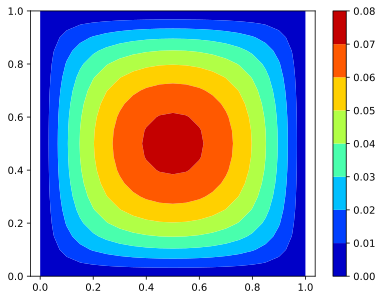

In [16]:
plt.contourf(X,Y,u,cmap=plt.cm.jet)
plt.axis('equal')
plt.colorbar();

The CG algorithm looks same as in the case of 1d BVP. Only the function `ax` is different.

**Remark**: We do not have to renumber the unknown, which is a 2-D array, into a one-dimensional vector. All quantities like search direction `p`, residual `res` are stored as 2-D array. The function `ax` takes a 2-D array and performs the matrix-vector product.